<a href="https://colab.research.google.com/github/roxacarv/edulearn/blob/main/Edulearn_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Plataforma Edulearn

#Clustering

In [2]:
#Importando as bibliotecas
from sklearn.cluster import KMeans
from sklearn import preprocessing
import plotly.graph_objects as go
from biokit.viz import corrplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Creating directory /root/.config/biokit 
Creating directory /root/.config/bioservices 


In [1]:
#Instalando a biblioteca biokit
#A versão atual do biokit (0.4.6) não é compatível com o Windows 10, é necessário instalar a versão 0.4.2, neste caso. 
!pip install biokit=="0.4.2"

     |████████████████████████████████| 115 kB 4.1 MB/s 
     |████████████████████████████████| 47 kB 4.4 MB/s 
     |████████████████████████████████| 255 kB 28.0 MB/s 
     |████████████████████████████████| 202 kB 50.9 MB/s 
     |████████████████████████████████| 2.3 MB 48.2 MB/s 
     |████████████████████████████████| 47 kB 4.1 MB/s 
     |████████████████████████████████| 44 kB 2.3 MB/s 
     |████████████████████████████████| 144 kB 67.7 MB/s 
     |████████████████████████████████| 5.8 MB 36.6 MB/s 
     |████████████████████████████████| 251 kB 35.1 MB/s 
     |████████████████████████████████| 127 kB 70.8 MB/s 
  Created wheel for biokit: filename=biokit-0.4.2-py3-none-any.whl size=139935 sha256=a4ddf88b506d39a47b4e8acbdce84d5a85ffb073b6760ad47764c399184a0c9e
  Stored in directory: /root/.cache/pip/wheels/9a/5e/5a/100cb42a3822d7accb1dd20eaf8da25629fbf6c63528cc0b67
  Created wheel for bioservices: filename=bioservices-1.8.2-py3-none-any.whl size=229884 sha256=ea078156f76e9c9

In [4]:
#Importando os dados
df = pd.read_csv("dados_ies.csv", sep=',', encoding='latin1', index_col=0)
df.head(4)

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
0,114,1,Pública Federal,Centro-Oeste,Mato Grosso,92.0,58.0,44.0,17.0,2.0,0.271930,0.429825,0.938596,0.201754,0.201754
1,149,2,Pública Federal,Centro-Oeste,Distrito Federal,39.0,32.0,27.0,32.0,8.0,2.778523,4.167785,3.704698,1.852349,1.852349
2,116,3,Pública Federal,Nordeste,Sergipe,190.0,56.0,94.0,16.0,2.0,0.775862,1.215517,1.793103,0.534483,0.534483
3,107,4,Pública Federal,Norte,Amazonas,64.0,33.0,54.0,60.0,2.0,0.000000,0.000000,0.719626,0.000000,0.000000


In [5]:
#Selecionando apenas as IES públicas
df = df.loc[df['TIPO_CATEGORIA_ADM'].isin(['Pública Federal','Pública Estadual','Pública Municipal'])]

#Substituindo os dados do formato string

In [6]:
#Substituindo o tipo de categoria administrativa para um código
categoria_adm = {
    'Pública Federal':1,
    'Pública Estadual':2,
    'Pública Municipal':3,
}
df.TIPO_CATEGORIA_ADM = df.TIPO_CATEGORIA_ADM.map(categoria_adm)
df.head()

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
0,114,1,1,Centro-Oeste,Mato Grosso,92.0,58.0,44.0,17.0,2.0,0.271930,0.429825,0.938596,0.201754,0.201754
1,149,2,1,Centro-Oeste,Distrito Federal,39.0,32.0,27.0,32.0,8.0,2.778523,4.167785,3.704698,1.852349,1.852349
2,116,3,1,Nordeste,Sergipe,190.0,56.0,94.0,16.0,2.0,0.775862,1.215517,1.793103,0.534483,0.534483
3,107,4,1,Norte,Amazonas,64.0,33.0,54.0,60.0,2.0,0.000000,0.000000,0.719626,0.000000,0.000000
4,100,5,1,Nordeste,Piauí,137.0,50.0,73.0,36.0,3.0,4.200000,5.880000,5.880000,2.520000,2.520000


In [7]:
#Substituindo o nome das regiões por códigos
regiao = {
    'Norte':1,
    'Nordeste':2,
    'Sudeste':3,
    'Sul':4,
    'Centro-Oeste':5,
}
df.REGIAO = df.REGIAO.map(regiao)
df.head()

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
0,114,1,1,5,Mato Grosso,92.0,58.0,44.0,17.0,2.0,0.271930,0.429825,0.938596,0.201754,0.201754
1,149,2,1,5,Distrito Federal,39.0,32.0,27.0,32.0,8.0,2.778523,4.167785,3.704698,1.852349,1.852349
2,116,3,1,2,Sergipe,190.0,56.0,94.0,16.0,2.0,0.775862,1.215517,1.793103,0.534483,0.534483
3,107,4,1,1,Amazonas,64.0,33.0,54.0,60.0,2.0,0.000000,0.000000,0.719626,0.000000,0.000000
4,100,5,1,2,Piauí,137.0,50.0,73.0,36.0,3.0,4.200000,5.880000,5.880000,2.520000,2.520000


In [8]:
#Substituindo o nome das unidades federativas por códigos
uf = {
    'Rondônia':11,
    'Acre':12,
    'Amazonas':13,
    'Roraima':14,
    'Pará':15,
    'Amapá':16,
    'Tocantins':17,
    'Maranhão':21,
    'Piauí':22,
    'Ceará':23,
    'Rio Grande do Norte':24,
    'Paraíba':25,
    'Pernambuco':26,
    'Alagoas':27,
    'Sergipe':28,
    'Bahia':29,
    'Minas Gerais':31,
    'Espírito Santo':32,
    'Rio de Janeiro':33,
    'São Paulo':35,
    'Paraná':41,
    'Santa Catarina':42,
    'Rio Grande do Sul':43,
    'Mato Grosso do Sul':50,
    'Mato Grosso':51,
    'Goiás':52,
    'Distrito Federal':53,
}
df.UF = df.UF.map(uf)
df.head()

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
0,114,1,1,5,51,92.0,58.0,44.0,17.0,2.0,0.271930,0.429825,0.938596,0.201754,0.201754
1,149,2,1,5,53,39.0,32.0,27.0,32.0,8.0,2.778523,4.167785,3.704698,1.852349,1.852349
2,116,3,1,2,28,190.0,56.0,94.0,16.0,2.0,0.775862,1.215517,1.793103,0.534483,0.534483
3,107,4,1,1,13,64.0,33.0,54.0,60.0,2.0,0.000000,0.000000,0.719626,0.000000,0.000000
4,100,5,1,2,22,137.0,50.0,73.0,36.0,3.0,4.200000,5.880000,5.880000,2.520000,2.520000


# Analisando os dados

In [9]:
df.describe()

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,44.340426,6287.914894,1.634043,2.893617,32.782979,24.923404,13.493617,25.446809,8.442553,1.502128,1.417101,1.745655,1.705928,0.913836,0.913836
std,50.358576,7549.619255,0.621989,1.000727,9.193534,42.951106,29.915746,53.700900,16.710196,3.100006,1.581439,2.121358,1.817401,1.041736,1.041736
min,1.000000,1.000000,1.000000,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,586.500000,1.000000,2.000000,29.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010227,0.315341,0.000000,0.000000
50%,29.000000,1876.000000,2.000000,3.000000,35.000000,7.000000,3.000000,6.000000,2.000000,0.000000,0.769231,0.911111,1.000000,0.500000,0.500000
75%,61.500000,15513.500000,2.000000,3.000000,35.000000,28.500000,16.500000,26.500000,8.000000,1.000000,2.367018,2.700000,2.571895,1.495614,1.495614
max,296.000000,24672.000000,3.000000,5.000000,53.000000,284.000000,349.000000,351.000000,117.000000,17.000000,6.000000,9.000000,8.000000,4.000000,4.000000


#Matriz de Correlação

In [10]:
#Usando matriz de correlação
matriz_corr = df.corr()
matriz_corr

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
NUM_CURSOS,1.000000,-0.484095,-0.372568,0.000552,-0.050091,0.509808,0.320101,0.396641,0.493697,0.471304,0.034708,0.086738,0.112963,0.045523,0.045523
CODIGO_IES,-0.484095,1.000000,0.201484,0.024226,0.071824,-0.333358,-0.241555,-0.276937,-0.280367,-0.278435,-0.100866,-0.143418,-0.175059,-0.108491,-0.108491
TIPO_CATEGORIA_ADM,-0.372568,0.201484,1.000000,0.163755,0.215485,-0.413605,-0.337739,-0.254170,-0.319042,-0.363076,-0.159693,-0.171520,-0.243295,-0.163859,-0.163859
REGIAO,0.000552,0.024226,0.163755,1.000000,0.979433,-0.160562,-0.015939,-0.087142,-0.021195,-0.105309,0.001365,-0.002801,-0.027811,0.001936,0.001936
UF,-0.050091,0.071824,0.215485,0.979433,1.000000,-0.198570,-0.037413,-0.109899,-0.050000,-0.117618,-0.008430,-0.012174,-0.050802,-0.007116,-0.007116
DEFICIENCIA_FISICA,0.509808,-0.333358,-0.413605,-0.160562,-0.198570,1.000000,0.436269,0.537808,0.621768,0.529902,0.226194,0.259229,0.306920,0.218947,0.218947
DEFICIENCIA_AUDITIVA,0.320101,-0.241555,-0.337739,-0.015939,-0.037413,0.436269,1.000000,0.353941,0.345905,0.292925,0.290759,0.326036,0.368816,0.295526,0.295526
DEFICIENCIA_VISUAL,0.396641,-0.276937,-0.254170,-0.087142,-0.109899,0.537808,0.353941,1.000000,0.579342,0.481361,0.246420,0.294198,0.338536,0.254921,0.254921
DEFICIENCIA_COGNITIVA,0.493697,-0.280367,-0.319042,-0.021195,-0.050000,0.621768,0.345905,0.579342,1.000000,0.547599,0.218259,0.259359,0.290097,0.224078,0.224078
DEFICIENCIA_MULTIPLA,0.471304,-0.278435,-0.363076,-0.105309,-0.117618,0.529902,0.292925,0.481361,0.547599,1.000000,0.143601,0.165877,0.209507,0.144432,0.144432


/usr/local/lib/python3.7/dist-packages/biokit/viz/linkage.py:41: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/usr/local/lib/python3.7/dist-packages/biokit/viz/corrplot.py:335: MatplotlibDeprecationWarning:


The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.



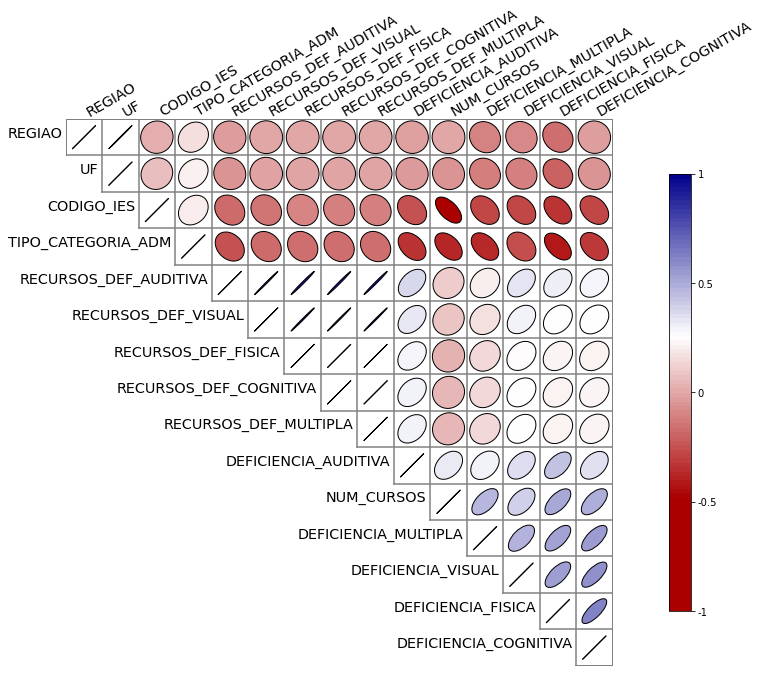

In [11]:
#Observando a correlação entre os dados
corr_graf = corrplot.Corrplot(matriz_corr)
corr_graf.plot(upper = 'ellipse', fontsize = 'x-large')
fig = plt.gcf()
fig.set_size_inches(40, 15)
fig.show()

#Normalização

In [12]:
df.columns

Index(['NUM_CURSOS', 'CODIGO_IES', 'TIPO_CATEGORIA_ADM', 'REGIAO', 'UF',
       'DEFICIENCIA_FISICA', 'DEFICIENCIA_AUDITIVA', 'DEFICIENCIA_VISUAL',
       'DEFICIENCIA_COGNITIVA', 'DEFICIENCIA_MULTIPLA', 'RECURSOS_DEF_FISICA',
       'RECURSOS_DEF_VISUAL', 'RECURSOS_DEF_AUDITIVA',
       'RECURSOS_DEF_COGNITIVA', 'RECURSOS_DEF_MULTIPLA'],
      dtype='object')

In [13]:
#Normalização manual
atributos = df.columns
for atributo in atributos:
    df[atributo] = (df[atributo] - min(df[atributo]))/(max(df[atributo]) - min(df[atributo]))

In [14]:
df.describe()

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,0.146917,0.254830,0.317021,0.473404,0.518642,0.087758,0.038664,0.072498,0.072159,0.088360,0.236183,0.193962,0.213241,0.228459,0.228459
std,0.170707,0.306012,0.310995,0.250182,0.218894,0.151236,0.085718,0.152994,0.142822,0.182353,0.263573,0.235706,0.227175,0.260434,0.260434
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010169,0.023732,0.000000,0.250000,0.428571,0.003521,0.000000,0.002849,0.000000,0.000000,0.000000,0.001136,0.039418,0.000000,0.000000
50%,0.094915,0.076000,0.500000,0.500000,0.571429,0.024648,0.008596,0.017094,0.017094,0.000000,0.128205,0.101235,0.125000,0.125000,0.125000
75%,0.205085,0.628775,0.500000,0.500000,0.571429,0.100352,0.047278,0.075499,0.068376,0.058824,0.394503,0.300000,0.321487,0.373904,0.373904
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#Clusterização dos dados

##1- Usando o K-means

In [15]:
from sklearn.cluster import KMeans

In [16]:
df.describe()

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,0.146917,0.254830,0.317021,0.473404,0.518642,0.087758,0.038664,0.072498,0.072159,0.088360,0.236183,0.193962,0.213241,0.228459,0.228459
std,0.170707,0.306012,0.310995,0.250182,0.218894,0.151236,0.085718,0.152994,0.142822,0.182353,0.263573,0.235706,0.227175,0.260434,0.260434
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010169,0.023732,0.000000,0.250000,0.428571,0.003521,0.000000,0.002849,0.000000,0.000000,0.000000,0.001136,0.039418,0.000000,0.000000
50%,0.094915,0.076000,0.500000,0.500000,0.571429,0.024648,0.008596,0.017094,0.017094,0.000000,0.128205,0.101235,0.125000,0.125000,0.125000
75%,0.205085,0.628775,0.500000,0.500000,0.571429,0.100352,0.047278,0.075499,0.068376,0.058824,0.394503,0.300000,0.321487,0.373904,0.373904
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
#Agrupando em 4 grupos
agrupador = KMeans(n_clusters = 4)
agrupador.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
labels = agrupador.labels_
print(labels)

[2 3 0 0 3 3 0 0 3 3 3 2 2 2 2 2 3 2 2 0 2 3 3 2 2 2 3 3 3 3 2 2 2 0 3 2 2
 2 0 0 2 2 0 3 0 0 0 3 3 0 3 3 0 3 3 0 3 3 0 0 2 0 0 0 3 2 0 3 0 3 0 0 0 0
 2 2 2 0 3 3 0 2 0 2 2 2 2 2 2 2 2 3 2 0 2 3 2 2 2 3 0 2 3 2 3 2 3 2 0 0 0
 0 2 0 0 0 3 2 0 0 0 2 0 2 0 0 0 0 0 0 2 0 2 3 2 0 3 2 2 2 3 2 3 0 0 2 2 0
 2 0 0 3 2 2 2 2 3 2 2 2 2 2 0 2 2 2 2 3 0 1 3 3 0 1 1 0 1 3 1 1 1 1 1 1 1
 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 1 1 1 1 3 1 1 1 3
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [19]:
#Visualizando os clusters
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['RECURSOS_DEF_FISICA'], y=df['DEFICIENCIA_FISICA'], 
                         mode = 'markers',
                         marker = dict(color = agrupador.labels_.astype(np.float)),
                         text = labels))
fig.show()

In [20]:
#Visualização em três dimensões
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=df['DEFICIENCIA_VISUAL'],
                          y=df['RECURSOS_DEF_VISUAL'],
                          z=df['TIPO_CATEGORIA_ADM'],
                          mode = 'markers',
                          marker = dict(color = agrupador.labels_.astype(np.float)),
                          text = labels))
fig.show()

In [21]:
#Agrupando em 3 grupos
agrupador = KMeans(n_clusters = 3)
agrupador.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [22]:
labels = agrupador.labels_
print(labels)

[1 2 1 1 2 2 1 1 2 2 2 1 1 0 0 0 2 0 0 1 1 2 2 0 1 1 2 2 2 2 0 0 1 1 2 1 0
 1 1 1 1 1 1 2 1 1 1 2 2 1 2 2 1 2 2 1 2 2 1 1 1 1 1 1 2 1 1 2 1 2 1 1 1 1
 0 0 0 1 2 2 1 1 1 1 0 0 0 0 1 0 1 2 0 1 0 2 0 0 1 2 1 0 2 0 2 1 2 0 1 1 1
 1 0 1 1 1 2 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 2 0 1 2 0 0 0 2 0 2 1 1 0 0 1
 0 1 1 2 0 0 0 0 2 1 0 1 0 0 1 0 0 1 0 2 1 0 2 2 1 0 1 1 0 2 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0 0 0 1 2 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 2]


In [23]:
#Visualizando os clusters
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['DEFICIENCIA_VISUAL'], y=df['RECURSOS_DEF_VISUAL'], 
                         mode = 'markers',
                         marker = dict(color = agrupador.labels_.astype(np.float)),
                         text = labels))
fig.show()

In [24]:
#Visualização em três dimensões
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=df['DEFICIENCIA_VISUAL'],
                          y=df['RECURSOS_DEF_VISUAL'],
                          z=df['TIPO_CATEGORIA_ADM'],
                          mode = 'markers',
                          marker = dict(color = agrupador.labels_.astype(np.float)),
                          text = labels))
fig.show()

#2 - Usando o algoritmo DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
agrupador = DBSCAN(eps = 1.31,
                   min_samples = 10,
                   metric = 'euclidean')
agrupador.fit(df)

DBSCAN(algorithm='auto', eps=1.31, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [ ]:
#Visualizando o número total de clusters
np.unique(agrupador.labels_)

array([-1,  0])

In [ ]:
#Quando reduzimos muito o epsilon, todos os dados são consideradas ruídos. Para se oranizar em clusters é necessário um número mínimo de 15 vizinhos.
agrupador = DBSCAN(eps=2, min_samples = 15, metric = 'euclidean')

# Observações: eps é a máxima distância entre os pontos/ mínimo de pontos é igual a 10/ a métrica de distância considerada'manhattan'
agrupador.fit(df)
agrupador.labels_

array([0, 0, 0, ..., 0, 0, 0])